In [2]:
import pandas as pd
import math
from collections import defaultdict
from scipy import stats
import statistics as st

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import numpy as np
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model

from pca import pca
from sklearn.cluster import KMeans

from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import pingouin as pg
from functools import reduce

# Stress, Coping Strategies, and Metacognitive Functions

Mental health has been gaining quite a lot of traction lately. This study contributes to the growing body of research on stress, coping strategies, and metacognitive functions. The first part of this notebook discusses the relationship between depression, anxiety, and stress levels. It may be counterintuitive, but their relationships is not as straightforward as it may seem. The second part inquires about the effectiveness of coping strategies. Are they all useful for forming metacognitive abilities such as planning or information management? Let's find out. 

In [3]:
#opening the excel file and getting familiar with the columns

df = pd.read_excel("Резльтаты Тестирования 1курс 2019.xlsx")
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df.rename(columns={df.columns[6]: "Holmes & Rahe Stress", 
                   df.columns[7]: "Depression Inventory", 
                   df.columns[8]: "Anxiety Inventory"}, inplace = True)
count = 0
for col in df.columns:
    count +=1
    print(col)
print(count)

участник 
E-mail
Group#
Gender 
Your age
Country you are from
Holmes & Rahe Stress
Depression Inventory
Anxiety Inventory
Confrontive
distancing
Self-control 
Seeking Social Support
Accepting Responsibility
Escape-Avoidance
Planful Problem Solving
Positive Reappraisal 
Declarative Knowledge (DK)
Procedural Knowledge (PK)
Conditional Knowledge (CK)
Planning
Information Management Strategies (IMS)
Comprehension Monitoring (M)
Debugging Strategies (D)
Evaluation
total
nan
nan
28


In [4]:
#descriptive stats
#gender ratio

women_count = len(df[df['Gender '] == 'female'])
print("Number of females = ", women_count)
male_count = len(df[df['Gender '] == 'male'])
print("Number of males = ", male_count)
print("Ratio = ", women_count/ (women_count + male_count) * 100, "women vs.",
     male_count, male_count/ (women_count + male_count) * 100, "men")


#country ratio

df_country = df['Country you are from'].value_counts(dropna=True).to_dict()
df_country["India"] = df_country["India"] + df_country["india"] + df_country["infia"]
df_country['Ecuador'] = df_country['ecvador'] + df_country['ewador']
df_country.pop('india', None)
df_country.pop('infia', None)
#df_country.pop['ecvador', None]
#df_country.pop['ewador', None]

for key, value in df_country.items():
    df_country[key] = math.ceil(value / sum(df_country.values()) * 100)
print(df_country)


gender = df['Gender '].tolist()
age = df['Your age'].tolist()
res = [(i, j) for i, j in zip(gender, age)]
cleaned_result = res[:len(res) - 3]
cleaned_result = [(i.lower(),j) for i,j in cleaned_result]


su_fem = 0
su_male = 0

list_of_ages = [tup[1] for tup in cleaned_result]
list_of_ages = [0 if math.isnan(x) else x for x in list_of_ages]
print(sum(list_of_ages))

mean_age = sum(list_of_ages)/ (len(list_of_ages) - 1)

print('Mean age =', mean_age)
for tup in cleaned_result:
    if tup[0] == 'female':
        su_fem += tup[1]
    elif tup[0] == 'male' and not math.isnan(tup[1]):
        su_male += tup[1]
print(su_male, male_count)
print("Mean age of females = ", su_fem / women_count)
print("Mean age of males = ", su_male / male_count)

Number of females =  40
Number of males =  110
Ratio =  26.666666666666668 women vs. 110 73.33333333333333 men
{'egypt ': 17, 'India': 72, 'bangladesh': 4, 'indonesia': 3, 'palestine': 2, 'Tunisia': 1, 'algeria': 1, 'france': 1, 'uae': 1, 'Pakistan': 1, 'india ': 1, 'Uzbekistan ': 1, 'turkey': 1, 'sudan': 1, 'nigeria': 1, 'ecvador': 1, 'iran': 1, 'ewador': 1, 'Iraq': 1, 'pakistan': 1, 'gabon': 1, 'colombia': 1, 'venezuela': 1, 'Ecuador': 2}
3415
Mean age = 20.207100591715978
2463 110
Mean age of females =  23.8
Mean age of males =  22.39090909090909


In [7]:
#more cleaning to get rid of irrelevant data and conceal private information

#number_of_rows = len(index)
df1 = df[0:170]
df1 = df1.iloc[:, 3:26]
df1['Gender '] = df1['Gender '].apply(lambda x: x.lower())
print(df1)

0   Gender  Your age Country you are from  Holmes & Rahe Stress  \
1    female       19               egypt                  219.0   
2    female       20               egypt                  214.0   
3      male       20                india                 446.0   
4      male       20               india                   91.0   
5      male       17                india                 456.0   
..      ...      ...                  ...                   ...   
166    male       23                india                 287.0   
167  female       19               egypt                  100.0   
168    male       23                india                 262.0   
169  female       22                india                  63.0   
170    male       22                india                  80.0   

0    Depression Inventory  Anxiety Inventory Confrontive distancing  \
1                    21.0               23.0          11         13   
2                    21.0               20.0         

In [8]:
def for_ttest(col1, col2):
    
    """this function conducts a t-test for a certain characteristic (col2)
    based on a demographic trait (col1)"""
    
    col1 = df1[col1].tolist()
    col2 = df1[col2].tolist()
    setcol1 = set(col1)
    res = [(i, j) for i, j in zip(col1, col2)]
    list_of_lists = [[] for x in range(len(setcol1))]
    for idx, i in enumerate(list(setcol1)):
        for tup in res:
            if tup[0] == i and not math.isnan(tup[1]):
                list_of_lists[idx].append(tup[1])
    statistic, pvalue = stats.ttest_ind(list_of_lists[0],list_of_lists[1])
    return st.mean(list_of_lists[0]), st.mean(list_of_lists[1]), statistic, pvalue


#we are only interested in t-tests where the alternative hypothesis is confirmed. Hence we're filtering out
#all the ttests where p > 0.05

for col in df1[df1.columns[df.columns.get_loc("Holmes & Rahe Stress"): df.columns.get_loc("Evaluation") + 1]]:
    if for_ttest('Gender ', col)[3] < 0.05:        
        print(col, for_ttest('Gender ', col))

Accepting Responsibility (8.170212765957446, 6.902439024390244, 2.7691184775894038, 0.0062527835422796245)
Positive Reappraisal  (13.808510638297872, 12.268292682926829, 2.207396405049154, 0.028641473748355923)
Comprehension Monitoring (M) (4.891304347826087, 5.553719008264463, -2.5877277432972505, 0.010522506326624761)


Based on the output, we can tell that the two genders show very different results when it comes to coping strategies such as *Accepting Responsibility* and *Positive Reappraisal*. There is also a difference regarding how sexes use *Comprehension Monitoring*. 

Now let's check our first hypotheses:
H0: Stress does not impact depression and anxiety levels. 
H1. Stress does impact depression and anxiety levels. 

As we see below, based on the R-squared value (<0.8), the null hypoethesis is confirmed. The graphs below shows the absense of any obvious linear relationship.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.660
Method:                 Least Squares   F-statistic:                              330.7
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    1.24e-41
Time:                        23:33:25   Log-Likelihood:                         -1074.2
No. Observations:                 170   AIC:                                      2150.
Df Residuals:                     169   BIC:                                      2154.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

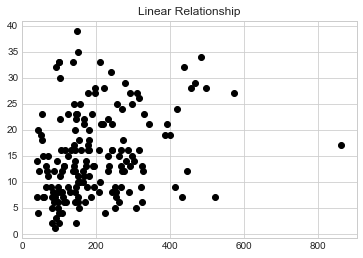

In [9]:


plt.plot(df1['Holmes & Rahe Stress'].tolist(), df1['Depression Inventory'].tolist(), 'o', color='black');
plt.title("Linear Relationship")

model = sm.OLS(df1['Holmes & Rahe Stress'].tolist(), df1['Depression Inventory'].tolist(), missing='drop').fit()
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.628
Model:                            OLS   Adj. R-squared (uncentered):              0.626
Method:                 Least Squares   F-statistic:                              285.4
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    3.89e-38
Time:                        23:33:26   Log-Likelihood:                         -1082.3
No. Observations:                 170   AIC:                                      2167.
Df Residuals:                     169   BIC:                                      2170.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, 'Linear Relationship Exists')

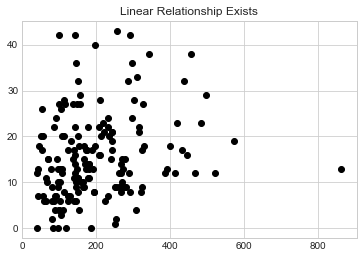

In [10]:
model = sm.OLS(df1['Holmes & Rahe Stress'].tolist(), df1['Anxiety Inventory'].tolist(), missing='drop').fit()
print_model = model.summary()
print(print_model)

plt.plot(df1['Holmes & Rahe Stress'].tolist(), df1['Anxiety Inventory'].tolist(), 'o', color='black');
plt.title("Linear Relationship Exists")

Just in case, we also checked the relationship between variables such as depression and anxiety. As expected, they predict each other, and the association is quite strong (R^2 > 0.829, p < 0.05). But as it often happens in psychology and social sciences, it is difficult to determine which variable is independent (predictor) and which is dependent (consequence).  

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.829
Model:                            OLS   Adj. R-squared (uncentered):              0.828
Method:                 Least Squares   F-statistic:                              818.6
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    1.10e-66
Time:                        23:33:27   Log-Likelihood:                         -574.66
No. Observations:                 170   AIC:                                      1151.
Df Residuals:                     169   BIC:                                      1154.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

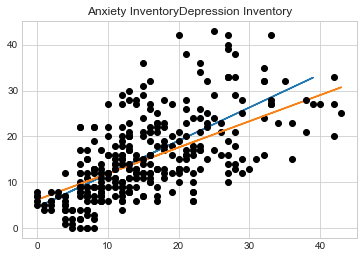

In [11]:
def linreg_and_plot(df, iv, dv):
    """this function generates a linear model summary
    and creates a linear regression graph"""
    
    x_iv = df[iv].tolist()
    y_dv = df[dv].tolist()
    
    model = sm.OLS(x_iv, y_dv, missing='drop').fit()
    print_model = model.summary()
    print(print_model)
    
    m, b = np.polyfit(x_iv, y_dv, 1)
    m = float(m)
    b = float(b)
    y = [m * x + b for x in x_iv]
    
    plt.plot(x_iv, y)
    plt.plot(x_iv, y_dv, 'o', color='black')
    plt.title(iv + dv)
    
print(linreg_and_plot(df1, 'Depression Inventory', 'Anxiety Inventory'))
print(linreg_and_plot(df1, 'Anxiety Inventory', 'Depression Inventory'))

But maybe we can gain better insighst if we control by some characteristics? Could it be that women and men react differently to stress, and one gender is more likely to get depressed or anxious as a result of stressful evensts?

In [12]:
#slicing df1 to leave only the relevant columns
controlled_for_gender = df1.iloc[:, [df1.columns.get_loc("Gender "), df1.columns.get_loc("Country you are from"), df1.columns.get_loc("Holmes & Rahe Stress"), df1.columns.get_loc("Depression Inventory"), df1.columns.get_loc("Anxiety Inventory")]]
print(controlled_for_gender)

def controlled(X, Y):
    """this function only fetches the results for 
    a selected characteristic such as gender"""
    
    data = list(zip(controlled_for_gender['Gender '].tolist(), list(zip(controlled_for_gender[X].tolist(), controlled_for_gender[Y].tolist()))))
    list_for_f = [tup[1] for tup in data if tup[0] == 'female']
    list_for_m = [tup[1] for tup in data if tup[0] == 'male']
    list_for_f_ord = list(map(list, zip(*list_for_f)))
    list_for_m_ord = list(map(list, zip(*list_for_m)))
    return list_for_f_ord, list_for_m_ord

0   Gender  Country you are from  Holmes & Rahe Stress  Depression Inventory  \
1    female               egypt                  219.0                  21.0   
2    female               egypt                  214.0                  21.0   
3      male                india                 446.0                  12.0   
4      male               india                   91.0                   3.0   
5      male                india                 456.0                  28.0   
..      ...                  ...                   ...                   ...   
166    male                india                 287.0                  16.0   
167  female               egypt                  100.0                  33.0   
168    male                india                 262.0                   6.0   
169  female                india                  63.0                   9.0   
170    male                india                  80.0                   2.0   

0    Anxiety Inventory  
1             

Hmmm, it looks like female participants show a stronger relationship between depression and anxiety than male participants do! 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.839
Method:                 Least Squares   F-statistic:                              245.8
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    4.47e-20
Time:                        23:33:32   Log-Likelihood:                         -162.29
No. Observations:                  47   AIC:                                      326.6
Df Residuals:                      46   BIC:                                      328.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

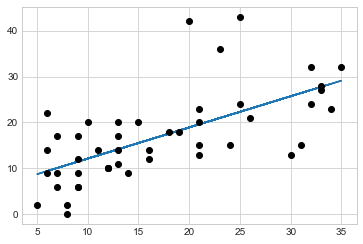

In [13]:
x_fem_dep = controlled('Depression Inventory', 'Anxiety Inventory')[0][0] 
y_fem_an = controlled('Depression Inventory', 'Anxiety Inventory')[0][1]

model = sm.OLS(x_fem_dep, y_fem_an, missing='drop').fit()
print_model = model.summary()
print(print_model)

m, b = np.polyfit(x_fem_dep, y_fem_an, 1)

m = float(m)
b = float(b)

y = [m * x + b for x in x_fem_dep]

plt.plot(x_fem_dep, y)
plt.plot(x_fem_dep, y_fem_an, 'o', color='black')

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.823
Model:                            OLS   Adj. R-squared (uncentered):              0.822
Method:                 Least Squares   F-statistic:                              569.0
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    9.10e-48
Time:                        23:33:33   Log-Likelihood:                         -411.40
No. Observations:                 123   AIC:                                      824.8
Df Residuals:                     122   BIC:                                      827.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

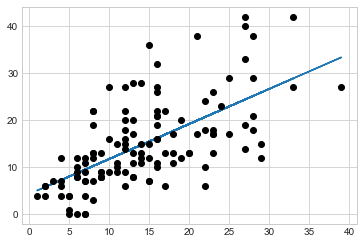

In [14]:
x_male_dep = controlled('Depression Inventory', 'Anxiety Inventory')[1][0] 
y_male_an = controlled('Depression Inventory', 'Anxiety Inventory')[1][1]

model = sm.OLS(x_male_dep, y_male_an, missing='drop').fit()
print_model = model.summary()
print(print_model)

m, b = np.polyfit(x_male_dep, y_male_an, 1)

m = float(m)
b = float(b)

y = [m * x + b for x in x_male_dep]

plt.plot(x_male_dep, y)
plt.plot(x_male_dep, y_male_an, 'o', color='black')

At the same time, women are slighly more likely to get depressed as a result of stress. Though this finding is not exactly reliable as its R-squared value is a bit below the minimum acceptable of 0.7. 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.684
Model:                            OLS   Adj. R-squared (uncentered):              0.677
Method:                 Least Squares   F-statistic:                              99.41
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    4.47e-13
Time:                        23:33:35   Log-Likelihood:                         -296.42
No. Observations:                  47   AIC:                                      594.8
Df Residuals:                      46   BIC:                                      596.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

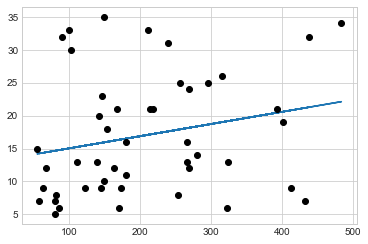

In [15]:
x_male_dep = controlled('Holmes & Rahe Stress', 'Depression Inventory')[0][0] 
y_male_an = controlled('Holmes & Rahe Stress', 'Depression Inventory')[0][1]

model = sm.OLS(x_male_dep, y_male_an, missing='drop').fit()
print_model = model.summary()
print(print_model)

m, b = np.polyfit(x_male_dep, y_male_an, 1)

m = float(m)
b = float(b)

y = [m * x + b for x in x_male_dep]

plt.plot(x_male_dep, y)
plt.plot(x_male_dep, y_male_an, 'o', color='black')

In [16]:
def controlled_country(X, Y):
    """this function divides datapoints into those belonging to
    participants from India and not from India"""
    
    data = list(zip(controlled_for_gender['Country you are from'].tolist(), list(zip(controlled_for_gender[X].tolist(), controlled_for_gender[Y].tolist()))))
    list_for_i = [tup[1] for tup in data if tup[0] == 'india']
    list_for_others = [tup[1] for tup in data if tup[0] != 'india']
    list_for_i_ord = list(map(list, zip(*list_for_i)))
    list_for_others_ord = list(map(list, zip(*list_for_others)))
    return list_for_i_ord, list_for_others_ord

Here we have a curious finding that apparently, Indian students are more likely to become anxious from stress than students from other countries. Without further research, we can't make any informed guesses why it's this way. Should we ask them and offer friendly help?

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.673
Model:                            OLS   Adj. R-squared (uncentered):              0.668
Method:                 Least Squares   F-statistic:                              152.0
Date:                Tue, 20 Oct 2020   Prob (F-statistic):                    1.29e-19
Time:                        23:33:37   Log-Likelihood:                         -467.53
No. Observations:                  75   AIC:                                      937.1
Df Residuals:                      74   BIC:                                      939.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

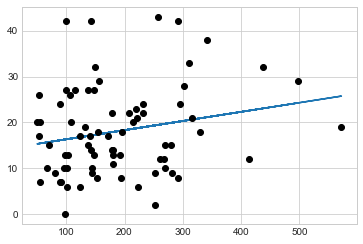

In [17]:
x_ind_stress = controlled_country('Holmes & Rahe Stress', 'Anxiety Inventory')[1][0] 
y_ind_dep = controlled_country('Holmes & Rahe Stress', 'Anxiety Inventory')[1][1]

model = sm.OLS(x_ind_stress, y_ind_dep, missing='drop').fit()
print_model = model.summary()
print(print_model)

m, b = np.polyfit(x_ind_stress, y_ind_dep, 1)

m = float(m)
b = float(b)

y = [m * x + b for x in x_ind_stress]

plt.plot(x_ind_stress, y)
plt.plot(x_ind_stress, y_ind_dep, 'o', color='black')

## PCA Analysis

PCA is used in exploratory data analysis and for making predictive models. It is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. 

After implementing PCA on the dataset, our original features turned into Principal Components. Principal Components are the linear combination of our original features. Principal Components are not as readable and interpretable as original features. For this reason, ultimately, we were not sure about our understanding of principal components and their application to clustering. 

In [18]:
#PCA analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [128]:
#standardization of features, a must for PCA

d = df1[df1.columns[df1.columns.get_loc("Confrontive"): df1.columns.get_loc("Positive Reappraisal\xa0") + 1]]
d = d.assign(target = df1['total'].values)
d.dropna()
print(d)

features = [col for col in d.columns if col != 'target']
x = d.loc[:, features].values
y = d.loc[:, ['target']].values
x = StandardScaler().fit_transform(x)

0   Confrontive distancing Self-control  Seeking Social Support  \
1            11         13            12                     15   
2             9          6            15                     11   
3            10          6             8                      8   
4             8          9             7                      9   
5            15         11            15                     13   
..          ...        ...           ...                    ...   
166           8         10            13                     13   
167          16          8            20                     10   
168           7         11            18                      9   
169           6          8             3                      0   
170           9         14            15                     11   

0   Accepting Responsibility Escape-Avoidance Planful Problem Solving  \
1                          8               14                       9   
2                         11                6    

In [107]:
#change of basis

model = PCA(n_components = 8)

principalComponents = model.fit_transform(x)

principalDataframe = pd.DataFrame(data = principalComponents, columns = ['1','2','3','4','5','6', '7','8'])

targetDataframe = d[['target']]

newDataframe = pd.concat([principalDataframe, targetDataframe],axis = 1)
print(newDataframe)

            1         2         3         4         5         6         7  \
0   -1.145766  0.185050 -1.218812  0.974082  0.267844  0.127919  0.206694   
1   -0.088084  0.993140  1.424505  0.376558 -1.376161 -0.324828  0.571531   
2    1.976903  0.683423 -0.599968 -0.417645 -0.305766  0.607038 -0.226903   
3    1.936621  0.284543  0.053031  0.634058  0.288121  0.235832 -0.191730   
4   -3.010908  0.866003 -0.320547 -0.477701 -0.134297  0.121344 -0.448550   
..        ...       ...       ...       ...       ...       ...       ...   
166 -3.343634  0.817546  1.435414 -1.312183 -1.224094  0.165120  0.087289   
167 -0.543104 -0.354544  0.490864 -0.235970 -0.397231 -1.596677  0.800223   
168  5.012175 -0.607235 -0.138842 -0.999653  1.128954 -0.043466 -0.754544   
169 -2.096953 -0.509283 -0.581563  0.420879  0.014755 -0.947788 -0.367147   
170       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            8 target  
0   -0.841662    NaN  
1   -0.962690     39  
2   -0

In [108]:
#finding best features that could represent the entire dataset

modeling = pca()
out = modeling.fit_transform(x)
print(out['topfeat'])

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [8] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
    PC feature   loading  type
0  PC1       7 -0.387393  best
1  PC2       4  0.571871  best
2  PC3       6 -0.579363  best
3  PC4       1 -0.538272  best
4  PC5       2  0.544318  best
5  PC6       8 -0.624111  best
6  PC7       3  0.618049  best
7  PC8       1 -0.526170  best
8  PC3       5  0.557096  weak


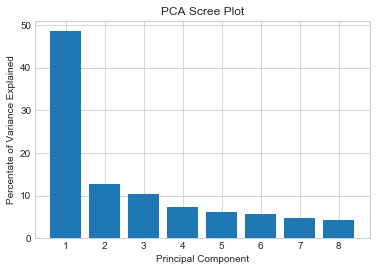

In [109]:
#creating a bar chart showing how many percents of variance in the dataset each feature is responsible for

percent_variance = np.round(model.explained_variance_ratio_* 100, decimals =2)
columns = ['1','2','3','4','5','6', '7','8']
plt.bar(x = range(1,9), height = percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

Text(0, 0.5, 'PC2')

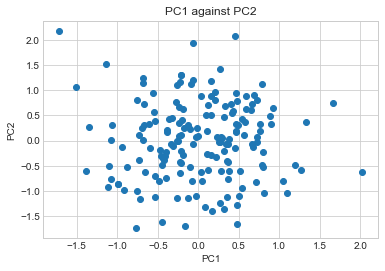

In [110]:
#our dataset after principal component decomposition, now represented only with two components

plt.scatter(principalDataframe['7'], principalDataframe['4'])
plt.title('PC1 against PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [111]:
#the percentage of variance for each component

model.explained_variance_ratio_

array([0.48507272, 0.12771468, 0.1027021 , 0.07412351, 0.06150474,
       0.05797101, 0.0486245 , 0.04228676])

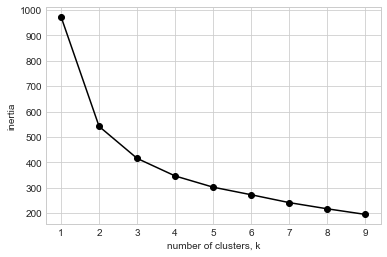

In [112]:
#elbow method for determining the most optimal number of clusters

ks = range(1, 10)
inertias = [] 
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(principalDataframe.iloc[:,:3])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

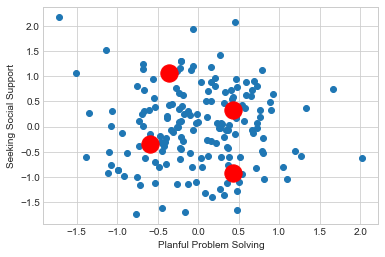

In [124]:
#K-means clustering
#At first glance, there are no obvious clusters

X = principalDataframe[['7', '4']].copy()

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X['7'], X['4'])
plt.xlabel('Planful Problem Solving')
plt.ylabel('Seeking Social Support')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [125]:
frame = pd.DataFrame(X)
frame['cluster'] = pred_y
print(frame)
frame['cluster'].value_counts()

            7         4  cluster
0    0.206694  0.974082        0
1    0.571531  0.376558        3
2   -0.226903 -0.417645        1
3   -0.191730  0.634058        0
4   -0.448550 -0.477701        1
..        ...       ...      ...
165  0.886011  0.489482        3
166  0.087289 -1.312183        2
167  0.800223 -0.235970        3
168 -0.754544 -0.999653        1
169 -0.367147  0.420879        0

[170 rows x 3 columns]


3    58
1    50
2    34
0    28
Name: cluster, dtype: int64

Total:

Cluster 0: Low problem solving, high seeking social support

Cluster 1: Low problem solving, low seeking social support

Cluster 2: High problem solving, low seeking social support

Cluster 3: High problem solving, high seeking social support

The clusters with the largest population are 3 and 1. The smallest number of people falls into cluster 0.

In [126]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Univariate Selection

Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable. These methods are simple to run and understand and are in general particularly good for gaining a better understanding of data (but not necessarily for optimizing the feature set for better generalization). There are lot of different options for univariate selection.

One of the simplest method for understanding a feature’s relation to the response variable is Pearson correlation coefficient, which measures linear correlation between two variables. The resulting value lies in -1;1, with -1 meaning perfect negative correlation (as one variable increases, the other decreases), +1 meaning perfect positive correlation and 0 meaning no linear correlation between the two variables.

In [137]:
#univariate selection
d = df1[df1.columns[df1.columns.get_loc("Confrontive"): df1.columns.get_loc("Positive Reappraisal\xa0") + 1]]
d = d.assign(target = df1['total'].values)

print([col for col in d])

d = d.dropna()

X = d.iloc[:,0:d.columns.get_loc("target")]
y = d.iloc[:,-1]
y = y.astype('int')

bestfeatures = SelectKBest(score_func = chi2, k = 8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))

['Confrontive', 'distancing', 'Self-control ', 'Seeking Social Support', 'Accepting Responsibility', 'Escape-Avoidance', 'Planful Problem Solving', 'Positive Reappraisal\xa0', 'target']
                      Specs      Score
3    Seeking Social Support  58.153879
6   Planful Problem Solving  55.576721
5          Escape-Avoidance  54.438691
2             Self-control   43.616738
0               Confrontive  40.820897
7     Positive Reappraisal   40.024954
1                distancing  30.412428
4  Accepting Responsibility  29.592686


As we see, *Seeking Social Support* seems to be the best predictor of metacognitive abilities. Let's use linear regression to check how correlated these variables are. The summary belows a not-so-bad R^2 value with p < 0.05. But could this model be improved if instead, we selected several best features to predict the metacognitive scores?

In [145]:
x_ind = d['Seeking Social Support'].tolist()
y_ind = d['target'].tolist()

x_ind = np.array([x_ind]).reshape((-1,1))
                 
regr = linear_model.LinearRegression()
regr.fit(x_ind, y_ind)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

model = sm.OLS(d['Seeking Social Support'].tolist(), d['target'].tolist(), missing='drop').fit()
print_model = model.summary()
print(print_model)
print(model.pvalues)

Intercept: 
 41.06580479046642
Coefficients: 
 [-0.03397029]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.821
Model:                            OLS   Adj. R-squared (uncentered):              0.820
Method:                 Least Squares   F-statistic:                              759.3
Date:                Wed, 21 Oct 2020   Prob (F-statistic):                    7.94e-64
Time:                        00:22:37   Log-Likelihood:                         -474.03
No. Observations:                 167   AIC:                                      950.1
Df Residuals:                     166   BIC:                                      953.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|     

In [146]:
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

### Random Forest for Feature Importance

Random forests are among the most popular machine learning methods thanks to their relatively good accuracy, robustness and ease of use. They also provide two straightforward methods for feature selection: mean decrease impurity and mean decrease accuracy.

In [153]:
X_train,X_test, y_train,y_test = train_test_split(X,y)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(len(X_train), len(y_train), len(X_test), len(y_test))

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 0))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(list(selected_feat))

125 125 42 42
['Escape-Avoidance', 'Planful Problem Solving', 'Positive Reappraisal\xa0']


In [154]:
list_of_factors = ['Escape-Avoidance', 'Planful Problem Solving', 'Positive Reappraisal\xa0']
new = d[list_of_factors].copy()
corr = new.astype('float64').corr().astype('float64')
top_corr_features = corr.index
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [155]:
X = d[list_of_factors]
Y = d['target']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 34.70059703155069
Coefficients: 
 [ 0.1005672   0.50014543 -0.02079642]


And just like magic, we bump up the fitness of the model to a whopping 0.925! Now we can conclude that it is the participants who use coping strategies such as *'Escape-Avoidance', 'Planful Problem Solving', and 'Positive Reappraisal'* are the most likely to have high metacognitive scores.  

In [156]:
model = sm.OLS(Y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              676.7
Date:                Wed, 21 Oct 2020   Prob (F-statistic):                    4.26e-92
Time:                        00:25:25   Log-Likelihood:                         -642.05
No. Observations:                 167   AIC:                                      1290.
Df Residuals:                     164   BIC:                                      1299.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [157]:
#correlation map
dataTypeDict = dict(d.dtypes)
print(dataTypeDict)
corrmat = d.corr()
print(corrmat)
top_corr_features = corrmat.index
print(top_corr_features)
plt.figure(figsize=(10,10))
#plot heat map
try:
    sns.heatmap(corrmat,annot=True,cmap="RdYlGn")
except ValueError: 
    pass

{'Confrontive': dtype('O'), 'distancing': dtype('O'), 'Self-control ': dtype('O'), 'Seeking Social Support': dtype('O'), 'Accepting Responsibility': dtype('O'), 'Escape-Avoidance': dtype('O'), 'Planful Problem Solving': dtype('O'), 'Positive Reappraisal\xa0': dtype('O'), 'target': dtype('O')}
Empty DataFrame
Columns: []
Index: []
Index([], dtype='object')


<Figure size 720x720 with 0 Axes>

### Factor Analysis

Factor analysis is a statistical method used to describe variability among observed, correlated variables in terms of a potentially lower number of unobserved variables called factors. For example, it is possible that variations in six observed variables mainly reflect the variations in two unobserved (underlying) variables. Factor analysis searches for such joint variations in response to unobserved latent variables. The observed variables are modelled as linear combinations of the potential factors, plus "error" terms. Factor analysis aims to find independent latent variables.

The theory behind factor analytic methods is that the information gained about the interdependencies between observed variables can be used later to reduce the set of variables in a dataset.

https://en.wikipedia.org/wiki/Factor_analysis

In [158]:
d_fa_coping = df1[df1.columns[df1.columns.get_loc("Confrontive"): df1.columns.get_loc("Positive Reappraisal\xa0") + 1]]
d_fa_metacog = df1[df1.columns[df1.columns.get_loc('Declarative Knowledge (DK)'): df1.columns.get_loc('Evaluation') + 1]]    

d_fa_coping.astype(float).dtypes

d_fa_metacog_1 = d_fa_metacog.dropna(axis=0, how='any')

In [111]:
#Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all 
chi_square_value,p_value = calculate_bartlett_sphericity(d_fa_coping.astype(float))
print('coping dataset', chi_square_value, p_value)

chi_square_value,p_value = calculate_bartlett_sphericity(d_fa_metacog_1.astype(float))
print('metacog dataset', chi_square_value, p_value)

coping dataset 479.02091177187407 6.574133888636929e-84
metacog dataset 379.3784517679194 1.3748655961444177e-63


In [113]:
#Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis
#values less than 0.6 are considered inadequate
kmo_all,kmo_model = calculate_kmo(d_fa_coping.astype(float))
print('Coping dataset', kmo_model)

kmo_all,kmo_model = calculate_kmo(d_fa_metacog_1.astype(float))
print('Metacog dataset', kmo_model)

Coping dataset 0.8497285277436702
Metacog dataset 0.8215058613010159


[3.88058172 1.0217174  0.82161677 0.59298806 0.49203789 0.46376808
 0.38899602 0.33829405]
[3.50532798 0.97660327 0.84801199 0.73594297 0.68552584 0.47698696
 0.4440122  0.3275888 ]


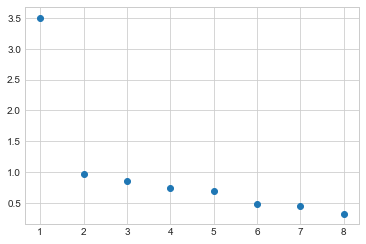

In [159]:
#elbow method for determining the best number of factors

fa = FactorAnalyzer()
fa.fit(d_fa_coping)
eigen_values, vectors = fa.get_eigenvalues()
print(eigen_values)

fa = FactorAnalyzer()
fa.fit(d_fa_metacog_1)
eigen_values, vectors = fa.get_eigenvalues()
print(eigen_values)

plt.scatter(range(1,d_fa_metacog_1.shape[1]+1),eigen_values)

In [160]:
fa = FactorAnalyzer(2, rotation='varimax')
fa.fit(d_fa_coping)
loads = fa.loadings_

df_coping = pd.DataFrame(loads, columns=['f1', 'f2'])
df_coping.insert (0, "Features", [col for col in d_fa_coping])
print(df_coping)

list_f1 = list(zip(df_coping['Features'].tolist(), df_coping['f1'].tolist()))
list_f1 = [x for x in list_f1 if x[1] > 0.5]
print(list_f1)

list_f2 = list(zip(df_coping['Features'].tolist(), df_coping['f2'].tolist()))
list_f2 = [x for x in list_f2 if x[1] > 0.5]
print(list_f2)

factor1 = d_fa_coping.astype(float)[[x[0] for x in list_f1]]
print(factor1)
factor2 = d_fa_coping.astype(float)[[x[0] for x in list_f2]]

print('Factor 1 Cronbach A', pg.cronbach_alpha(factor1))
print('Factor 2 Cronbach A', pg.cronbach_alpha(factor2))

                   Features        f1        f2
0               Confrontive  0.630254  0.364088
1                distancing  0.106584  0.755212
2             Self-control   0.393594  0.627381
3    Seeking Social Support  0.583167  0.141215
4  Accepting Responsibility  0.388069  0.450453
5          Escape-Avoidance  0.325367  0.567330
6   Planful Problem Solving  0.554429  0.455818
7     Positive Reappraisal   0.739941  0.229677
[('Confrontive', 0.6302536373874746), ('Seeking Social Support', 0.583166852036739), ('Planful Problem Solving', 0.5544287045601786), ('Positive Reappraisal\xa0', 0.7399414507581406)]
[('distancing', 0.7552119908837425), ('Self-control ', 0.6273813927388826), ('Escape-Avoidance', 0.5673302678241405)]
0    Confrontive  Seeking Social Support  Planful Problem Solving  \
1           11.0                    15.0                      9.0   
2            9.0                    11.0                      8.0   
3           10.0                     8.0                   

In [144]:
fa = FactorAnalyzer(2, rotation='varimax')
fa.fit(d_fa_metacog_1)
loads = fa.loadings_

df_metacog = pd.DataFrame(loads, columns=['f1', 'f2'])
df_metacog.insert (0, "Features", [col for col in d_fa_metacog_1])
print(d_fa_metacog_1)

list_f1 = list(zip(df_metacog['Features'].tolist(), df_metacog['f1'].tolist()))
list_f1 = [x for x in list_f1 if x[1] > 0.5]
print(list_f1)

list_f2 = list(zip(df_metacog['Features'].tolist(), df_metacog['f2'].tolist()))
list_f2 = [x for x in list_f2 if x[1] > 0.5]
print(list_f2)

factor1 = d_fa_metacog_1.astype(float)[[x[0] for x in list_f1]]
factor2 = d_fa_metacog_1.astype(float)[[x[0] for x in list_f2]]

print('Factor 1 Cronbach A', pg.cronbach_alpha(factor1))
print('Factor 2 Cronbach A', pg.cronbach_alpha(factor2))

0   Declarative Knowledge (DK) Procedural Knowledge (PK)  \
1                            6                         3   
2                            7                         3   
3                            8                         4   
4                            7                         2   
5                            5                         4   
..                         ...                       ...   
166                          8                         4   
167                          3                         4   
168                          4                         3   
169                          5                         1   
170                          8                         4   

0   Conditional Knowledge (CK) Planning  \
1                            4        4   
2                            4        5   
3                            5        7   
4                            5        5   
5                            4        3   
..                   

Coping Strategies:

Factor 1: Confronting + Seeking Social Support + Planful Problem Solving + Positive Reappraisal (Cronbach’s Alpha = 0.7797447348103161);

Factor 2: Distancing + Self-Control + Escape-Avoidance (Cronbach’s Alpha = 0.739881016196928).

We can see that Factor 2 has an overacrhing theme of avoiding and escaping as well as keeping a distance from the source of stress. Alas, Factor 1 is not as straightforward, though it may unite the proactive coping strategies. 

Metacognitive Abilities: 

Factor 1: 'Planning' + 'Comprehension Monitoring (M)' + 'Evaluation' (Cronbach’s Alpha = 0.78);

Factor 2: Procedural Knowledge (PK) + Information Management Strategies (IMS) (Cronbach’s Alpha = 0.62)